In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, TimeDistributed ,Reshape
# from tensorflow.keras.layers import LSTM, TimeDistributed

In [ ]:
# Emotions map from RAVDESS filename (3rd part in filename)
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


In [3]:

def extract_features(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # print(f"MFCCs shape for {file_path}: {mfccs.T.shape}")
    # return np.mean(mfccs.T, axis=0)
    return mfccs.T  # return full MFCCs for sequence models

def get_metspectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sr

def normalize_spectrogram(S_dB, max_len=200):
        # Normalize (0-1)
    S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    
    # Fix length (padding/truncating)
    # print(f"Original spectrogram shape: {S_dB.shape}")
    if S_dB.shape[1] < max_len:
        pad_width = max_len - S_dB.shape[1]
        S_dB = np.pad(S_dB, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        S_dB = S_dB[:, :max_len]
    # print(f"Normalized spectrogram shape: {S_dB.shape}")
    return S_dB


In [4]:

data = []
labels = []

dataset_path = r"data\audio_speech_actors_01-24"  # replace with your dataset folder

# Loop through actor directories
for actor in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor)
    if os.path.isdir(actor_path):  # ensure it's a folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file.split("-")[2]
                if emotion_code in emotion_dict:
                    emotion = emotion_dict[emotion_code]
                    S_dB,sr = get_metspectrogram(os.path.join(actor_path, file))
                    feature = normalize_spectrogram(S_dB, max_len=128).T  # Transpose to (time, n_mels)
                    # print(f"Processed {feature}, Emotion: {emotion}")
                    #feature will be in image format
                    data.append(feature)
                    labels.append(emotion)
print(f"Total samples: {len(data)}")
print(f"Sample feature shape: {data[0].shape if data else 'N/A'}")



Total samples: 1440
Sample feature shape: (128, 128)


In [9]:
X = np.array(data)

le = LabelEncoder()
y = np.array(le.fit_transform(labels))
y_cat = to_categorical(y, num_classes=8)  # one-hot

# CNN ke liye channel add
X = X[..., np.newaxis]   # shape: (samples, 128, 200, 1)


In [ ]:

data = []
labels = []

dataset_path = r"data\audio_speech_actors_01-24"  #  dataset folder


# Loop through actor directories
for actor in os.listdir(dataset_path):
    actor_path = os.path.join(dataset_path, actor)
    if os.path.isdir(actor_path):  # ensure it's a folder
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file.split("-")[2]
                if emotion_code in emotion_dict:
                    emotion = emotion_dict[emotion_code]
                    S_dB,sr = get_metspectrogram(os.path.join(actor_path, file))
                    feature = normalize_spectrogram(S_dB, max_len=200).T  # Transpose to (time, n_mels)
                    # print(f"Processed {feature}, Emotion: {emotion}")
                    #feature will be in image format
                    data.append(feature)
                    labels.append(emotion)

# 2. Find minimum length across dataset
min_len = min([feat.shape[0] for feat in data])
print("Minimum length of MFCC frames:", min_len)

# 3. Truncate all sequences to min_len
data_trunc = np.array([feat[:min_len, :] for feat in data])  # shape: (num_samples, min_len, n_mfcc)
X = data_trunc.reshape(data_trunc.shape[0], -1)  
y = np.array(labels)


print("Feature shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique emotions:", set(labels))

Processed [[-861.5326    0.        0.     ...    0.        0.        0.    ]
 [-861.5326    0.        0.     ...    0.        0.        0.    ]
 [-861.5326    0.        0.     ...    0.        0.        0.    ]
 ...
 [-861.5326    0.        0.     ...    0.        0.        0.    ]
 [-861.5326    0.        0.     ...    0.        0.        0.    ]
 [-861.5326    0.        0.     ...    0.        0.        0.    ]], Emotion: neutral
Processed [[-861.444    0.       0.    ...    0.       0.       0.   ]
 [-861.444    0.       0.    ...    0.       0.       0.   ]
 [-861.444    0.       0.    ...    0.       0.       0.   ]
 ...
 [-861.444    0.       0.    ...    0.       0.       0.   ]
 [-861.444    0.       0.    ...    0.       0.       0.   ]
 [-861.444    0.       0.    ...    0.       0.       0.   ]], Emotion: neutral
Processed [[-8.4550775e+02  8.0582581e+00  7.9402895e+00 ...  1.2460933e+00
   1.2820088e+00  1.3016369e+00]
 [-8.4432507e+02  9.7183437e+00  9.5644684e+00 ...  1.2

In [ ]:

def get_metspectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sr

Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-01-01-02-02-01.wav, Emotion: neutral
S_dB shape: (128, 298), Sample rate: 48000
Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-02-01-01-02-01.wav, Emotion: calm
S_dB shape: (128, 338), Sample rate: 48000
Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-03-01-01-01-01.wav, Emotion: happy
S_dB shape: (128, 326), Sample rate: 48000
Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-04-01-01-01-01.wav, Emotion: sad
S_dB shape: (128, 360), Sample rate: 48000
Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-05-01-01-01-01.wav, Emotion: angry
S_dB shape: (128, 363), Sample rate: 48000
Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-06-01-01-01-01.wav, Emotion: fearful
S_dB shape: (128, 345), Sample rate: 48000
Processing file: data\audio_speech_actors_01-24\Actor_01\03-01-07-01-01-01-01.wav, Emotion: disgust
S_dB shape: (128, 363), Sample rate: 48000
Processing

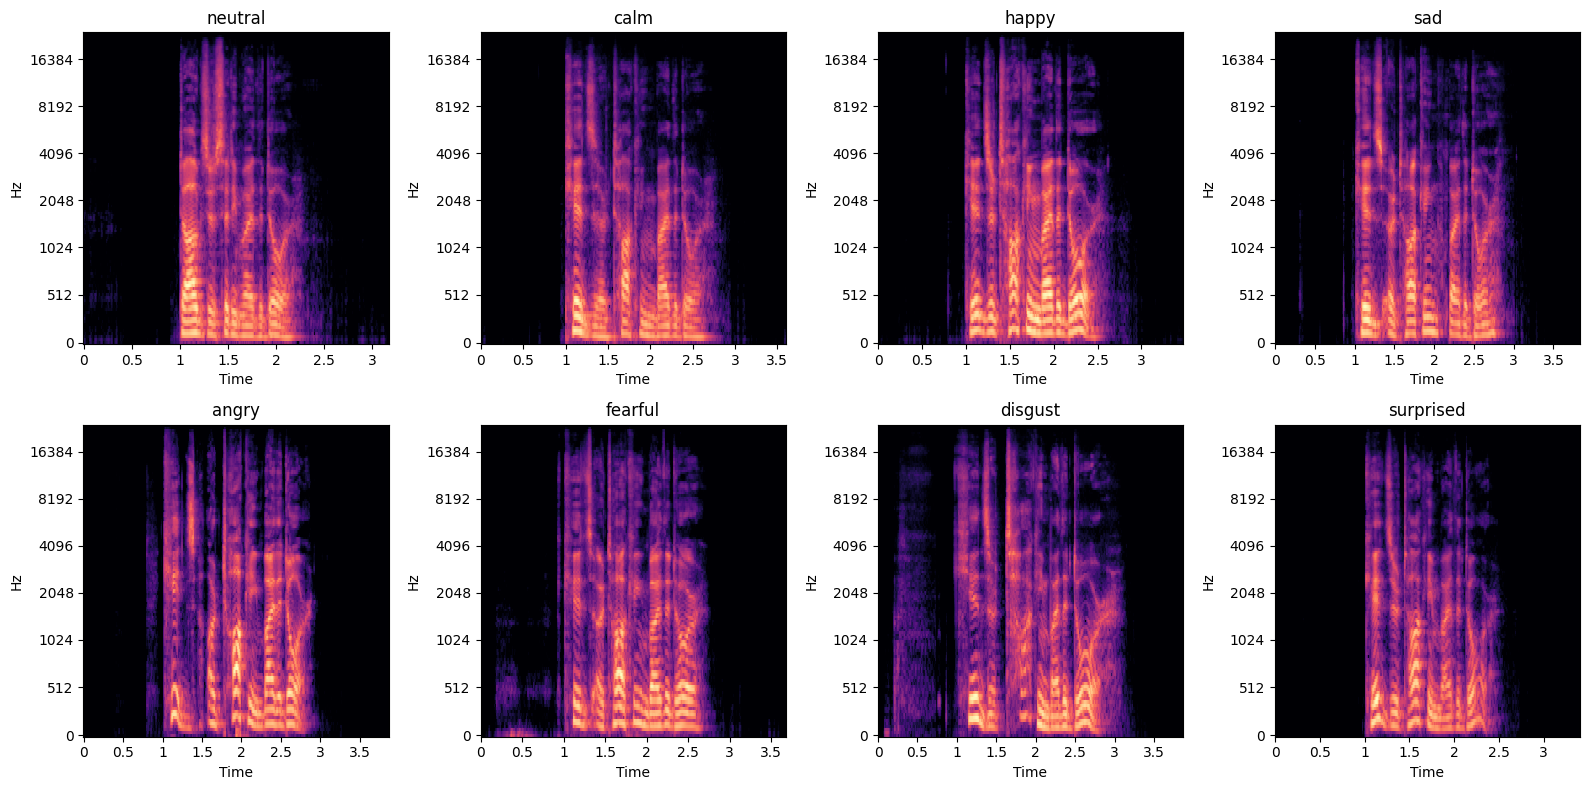

In [43]:
import librosa.display
import matplotlib.pyplot as plt

# Emotion codes mapping (RAVDESS me 01-08 emotions hote hain)
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def get_metspectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB, sr


def plot_spectrogram(S_dB, sr,file):
    emotion_code = file.split("-")[2]
    emotion = emotion_dict.get(emotion_code, "unknown")
    # plt.figure(figsize=(8, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
     
    # plt.colorbar(format='%+2.0f dB')
    # # plt.title("Mel Spectrogram")
    # plt.show()

path_list = [   r"data\audio_speech_actors_01-24\Actor_01\03-01-01-01-02-02-01.wav", 
                r"data\audio_speech_actors_01-24\Actor_01\03-01-02-01-01-02-01.wav",
                r"data\audio_speech_actors_01-24\Actor_01\03-01-03-01-01-01-01.wav", 
                r"data\audio_speech_actors_01-24\Actor_01\03-01-04-01-01-01-01.wav", 
                r"data\audio_speech_actors_01-24\Actor_01\03-01-05-01-01-01-01.wav", 
                r"data\audio_speech_actors_01-24\Actor_01\03-01-06-01-01-01-01.wav", 
                r"data\audio_speech_actors_01-24\Actor_01\03-01-07-01-01-01-01.wav",
                r"data\audio_speech_actors_01-24\Actor_01\03-01-08-01-01-01-01.wav", ]

# Subplot grid bana rahe hain (2 rows × 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, path in enumerate(path_list):
    row, col = divmod(i, 4)
    filename = os.path.basename(path)
    emotion_code = filename.split("-")[2]
    emotion = emotion_dict.get(emotion_code, "unknown")
    print(f"Processing file: {path}, Emotion: {emotion}")

    S_dB, sr = get_metspectrogram(path)
    print(f"S_dB shape: {S_dB.shape}, Sample rate: {sr}")
    # plot_spectrogram( S_dB, sr, path)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', ax=axes[row, col])

    axes[row, col].set_title(emotion)
    # axes[row, col].label_outer()

plt.tight_layout()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical
# Encode string labels to integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(40,)),
    # layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')  # 8 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=23,
                    validation_data=(X_test, y_test))


d:\sorce work\alphacode\emotionDetectionFromVoice\.venv\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,424 (173.53 KB)

 Trainable params: 44,424 (173.53 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1354 - loss: 17.3350 - val_accuracy: 0.1250 - val_loss: 2.1005
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1432 - loss: 2.0786 - val_accuracy: 0.1771 - val_loss: 2.0781
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1311 - loss: 2.0761 - val_accuracy: 0.1528 - val_loss: 2.0730
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1319 - loss: 2.0740 - val_accuracy: 0.1111 - val_loss: 2.0757
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1215 - loss: 2.0728 - val_accuracy: 0.1181 - val_loss: 2.0745
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1285 - loss: 2.0710 - val_accuracy: 0.1424 - val_loss: 2.0622
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1389 - loss: 2.0685 - val_accuracy: 0.1111 - val_loss: 2.0730
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1398 - loss: 2.0688 - val_accuracy: 0.1111 - val_loss

CNN Model


In [25]:


num_classes = len(np.unique(y))  # emotions ki count

model = Sequential([
    # 1st Conv Block
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # 2nd Conv Block
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # 3rd Conv Block
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


d:\sorce work\alphacode\emotionDetectionFromVoice\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,992 (12.61 MB)

 Trainable params: 3,305,544 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

In [24]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',       # monitor validation loss
    patience=5,               # stop after 5 epochs of no improvement
    restore_best_weights=True # restore best weights instead of last
)


In [27]:


# Train model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=1,
                    callbacks=[early_stop],
                    batch_size=32,
                    verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 466ms/step - accuracy: 0.1389 - loss: 2.1838 - val_accuracy: 0.1319 - val_loss: 111.4940


In [33]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    
    # Flatten(),
    # Flatten na karke reshape -> (time_steps, features)
    # maan lo output shape aa rahi hai (batch, 16, 16, 128)
    Reshape((16, 16*128)),

    # LSTM layers
    LSTM(128, return_sequences=False),  
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

d:\sorce work\alphacode\emotionDetectionFromVoice\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(14, 14, 128), target_shape=(16, 2048)

In [ ]:

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    # callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.6094 - loss: 1.0341 - val_accuracy: 0.3542 - val_loss: 1.8850
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.6484 - loss: 0.9675 - val_accuracy: 0.3611 - val_loss: 1.9698
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.7101 - loss: 0.7878 - val_accuracy: 0.3472 - val_loss: 2.0246
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.7222 - loss: 0.7365 - val_accuracy: 0.3611 - val_loss: 2.1002
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.7908 - loss: 0.5952 - val_accuracy: 0.3715 - val_loss: 2.2570
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8134 - loss: 0.4911 - val_accuracy: 0.3542 - val_loss: 2.3556
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8333 - loss: 0.4597 - val_accuracy: 0.3507 - val_loss: 2.5953
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.8377 - loss: 0.4072 - val_accuracy: 0.

KeyboardInterrupt: 